#**Netflix Movies and Shows Dataset -- Team Theta**





### Questions
##### 1. Which countries produce the most content on Netflix?  
##### 2. How has the number of movies released changed over the years?
##### 3. What are the most frequently occurring genres on Netflix?
##### 4. Based on the description what tv show/movie is most similar?

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.api as sm
import os
import math
import string
import ast
import random
!pip install clean-text
%matplotlib inline
#ML Libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
#  NLTK Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv('titles.csv')
df.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600


#Descriptive Analysis

In [2]:
# Info on data types, column names, counts, etc.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5850 entries, 0 to 5849
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5850 non-null   object 
 1   title                 5849 non-null   object 
 2   type                  5850 non-null   object 
 3   description           5832 non-null   object 
 4   release_year          5850 non-null   int64  
 5   age_certification     3231 non-null   object 
 6   runtime               5850 non-null   int64  
 7   genres                5850 non-null   object 
 8   production_countries  5850 non-null   object 
 9   seasons               2106 non-null   float64
 10  imdb_id               5447 non-null   object 
 11  imdb_score            5368 non-null   float64
 12  imdb_votes            5352 non-null   float64
 13  tmdb_popularity       5759 non-null   float64
 14  tmdb_score            5539 non-null   float64
dtypes: float64(5), int64(

In [3]:
# shape of the original df
df.shape

(5850, 15)

In [4]:
# the df described
df.describe()

,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
count,5850.000000,5850.000000,2106.000000,5368.000000,5.352000e+03,5759.000000,5539.000000
mean,2016.417094,76.888889,2.162868,6.510861,2.343938e+04,22.637925,6.829175
std,6.937726,39.002509,2.689041,1.163826,9.582047e+04,81.680263,1.170391
min,1945.000000,0.000000,1.000000,1.500000,5.000000e+00,0.009442,0.500000
25%,2016.000000,44.000000,1.000000,5.800000,5.167500e+02,2.728500,6.100000
50%,2018.000000,83.000000,1.000000,6.600000,2.233500e+03,6.821000,6.900000
75%,2020.000000,104.000000,2.000000,7.300000,9.494000e+03,16.590000,7.537500
max,2022.000000,240.000000,42.000000,9.600000,2.294231e+06,2274.044000,10.000000


In [5]:
# Correlation between features
corr =  df.corr()
corr.style.background_gradient(cmap='Reds')

,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
release_year,1.000000,-0.173551,-0.504407,-0.129380,-0.208815,0.043244,0.032073
runtime,-0.173551,1.000000,-0.139642,-0.148068,0.139760,0.002545,-0.277454
seasons,-0.504407,-0.139642,1.000000,0.106806,0.206079,0.168051,0.044023
imdb_score,-0.129380,-0.148068,0.106806,1.000000,0.190661,0.017675,0.570754
imdb_votes,-0.208815,0.139760,0.206079,0.190661,1.000000,0.209763,0.112960
tmdb_popularity,0.043244,0.002545,0.168051,0.017675,0.209763,1.000000,0.071894
tmdb_score,0.032073,-0.277454,0.044023,0.570754,0.112960,0.071894,1.000000


#Data Cleaning
##### A. Removing rows with imcompete datas (IE, missing votes/ ratings)
##### B. Removing columns that wont be utilized in order to make data set easier to read(runtime, age_cert, seasons, etc)
##### C. Reducing "genres" and "production_countries" to one tag.

In [6]:
# Dropping columns we do not need first
# columns = ID, Age, Runtime, Seasons, IMDB_ID)
df = df.drop(columns=["id", "age_certification","runtime", "seasons", "imdb_id"])

In [7]:
# Checking for duplicate values, then removing them.
dup_df = df.duplicated().any()
print("Any duplicate values?", dup_df) # returns False
# Checking for missing values, then removing them.
print("Any missing value?", df.isnull().values.any()) # returns True
df.dropna(axis = 0, inplace= True)
print(df.isnull().sum())

Any duplicate values? False
Any missing value? True
title                   0
type                    0
description             0
release_year            0
genres                  0
production_countries    0
imdb_score              0
imdb_votes              0
tmdb_popularity         0
tmdb_score              0
dtype: int64


In [8]:
# Filtering dataset to movies that were released after 2010.
# The purpose of this is to reduce dataset to more relevant information
#df = df[df['release_year'] > 2010]

In [9]:
# Cleaning the production_countries for readability
# Some title's have multiple production countries
df['production_countries'] = df['production_countries'].str.replace(r"[", '').str.replace(r"'", '').str.replace(r"]", '')
df['production_countries_2'] = df['production_countries'].str.split(',').str[0]
df.production_countries_2 = df.production_countries_2.replace('', np.nan)
#Dropping orginal production_countries column, renaming the second one
df.drop('production_countries', axis=1, inplace=True)
df.rename(columns={'production_countries_2': 'production_countries'}, inplace=True)
df.head()

,title,type,description,release_year,genres,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,production_countries
1,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,"['drama', 'crime']",8.2,808582.0,40.965,8.179,US
2,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,"['drama', 'action', 'thriller', 'european']",7.7,107673.0,10.010,7.300,US
3,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,"['fantasy', 'action', 'comedy']",8.2,534486.0,15.461,7.811,GB
4,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,"['war', 'action']",7.7,72662.0,20.398,7.600,GB
5,Monty Python's Flying Circus,SHOW,A British sketch comedy series with the shows ...,1969,"['comedy', 'european']",8.8,73424.0,17.617,8.306,GB


Pre-processing/Cleaning for Genre analysis below

In [10]:
df['genres'].value_counts()
# Due to the structure of the data, the method cannot parse the values in the most fitting manner.
# We must parse the genres ourselves.

['comedy']                                   423
['documentation']                            240
['drama']                                    230
['drama', 'romance']                         118
['comedy', 'drama']                          114
                                            ... 
['horror', 'fantasy', 'thriller']              1
['drama', 'action', 'war', 'history']          1
['scifi', 'crime', 'drama', 'thriller']        1
['drama', 'animation', 'family', 'music']      1
['animation', 'family', 'scifi']               1
Name: genres, Length: 1675, dtype: int64

In [11]:
# Modifying the get_genres function to transform the original columns
# We will only use the first element of each value in the genres column
# The first genre seems to be the one that represents the movie/show the most
def transform_genres(row):
    parsed = (str(row)[1:-1]).split(",")  
    genres = {}

    for i in range(len(parsed)):
        genre = parsed[i].strip()[1:-1]  # Remove surrounding quotes

        if genre != '':  # Check if genre is not empty
            if genre not in genres:
                genres[genre] = 0
            genres[genre] += 1  # Increment count

    return max(genres, key=genres.get) if genres else 'none'

# Performing the transformation
df['genres_transformed'] = df['genres'].map(transform_genres)
df['genres_transformed'].value_counts()

drama            1261
comedy           1192
documentation     547
thriller          343
action            328
animation         242
scifi             222
crime             220
romance           210
reality           154
family            100
horror            100
fantasy            79
music              47
war                42
history            21
western            15
sport               4
none                2
Name: genres_transformed, dtype: int64

In [12]:
# Dictionary to store genre counts
genres = {}

# Function to parse genres column
def get_genres(row):
    parsed = (str(row)[1:-1]).split(",")  # Remove brackets and split into list
    
    for i in range(len(parsed)):
        parsed[i] = parsed[i].strip()  # Remove leading/trailing spaces
        parsed[i] = parsed[i][1:-1]  # Remove single quotes around genres

    for i in parsed:
        if i not in genres:  # Checking if genre exists in dictionary
            genres[i] = 0  # Initialize count
        genres[i] += 1  # Increment count

    return row  # Return original row

# Apply function to transform 'genres' column
df['genres'] = df['genres'].map(get_genres)

# Print the final genres dictionary
print(genres)



{'drama': 2720, 'crime': 893, 'action': 1075, 'thriller': 1154, 'european': 424, 'fantasy': 609, 'comedy': 2146, 'war': 151, 'romance': 928, 'western': 39, 'documentation': 825, 'history': 249, 'music': 233, 'family': 637, 'horror': 358, 'scifi': 546, 'animation': 586, 'reality': 210, 'sport': 168, '': 2}


In [13]:
#Dropping orginal genres column, renaming the transformed one
df.drop('genres', axis=1, inplace=True)
df.rename(columns={'genres_transformed': 'genres'}, inplace=True)
df.head()

,title,type,description,release_year,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,production_countries,genres
1,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,8.2,808582.0,40.965,8.179,US,drama
2,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,7.7,107673.0,10.010,7.300,US,drama
3,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,8.2,534486.0,15.461,7.811,GB,fantasy
4,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,7.7,72662.0,20.398,7.600,GB,war
5,Monty Python's Flying Circus,SHOW,A British sketch comedy series with the shows ...,1969,8.8,73424.0,17.617,8.306,GB,comedy


#Exploratory Data Analysis - EDA

<Figure size 1500x1000 with 0 Axes>

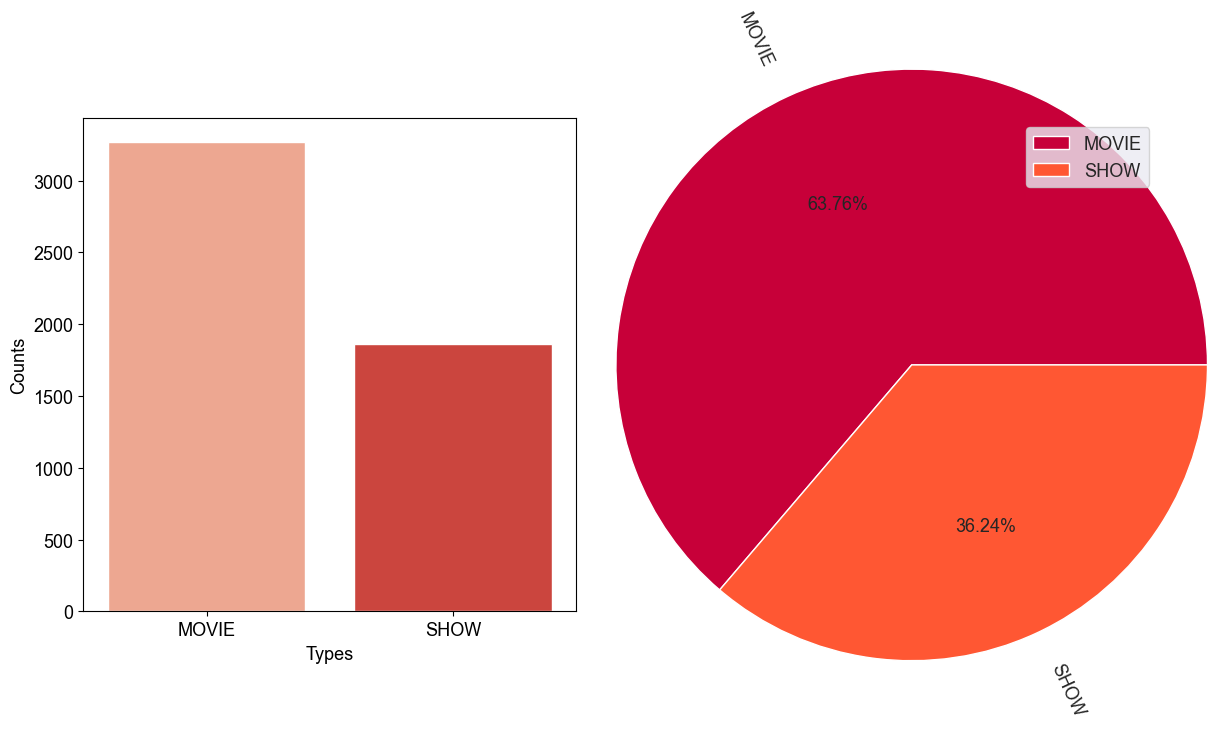

In [14]:
# Pie/Bar Charts of the dataset types
types = df.groupby('type').size().reset_index().rename(columns={0: 'counts'})  

# Function to set figure size
def figure_size():
    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(10)
    plt.rc('font', family='sans-serif', size=13)  

# Calling the function
figure_size()

langs = types['type'] 
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.tight_layout(pad=2)
sns.set_style("darkgrid")

# Bar Chart
a1 = sns.barplot(x=types['type'], y=types['counts'], ax=axes[0], palette='Reds')
a1.set(xlabel='Types', ylabel='Counts')

# Pie Chart
axes[1].pie(
    types['counts'], autopct='%1.2f%%', labels=langs, radius=1.5, 
    labeldistance=1.1, rotatelabels=True, colors=['#C70039', '#FF5733']
)
axes[1].legend()

# Display the plots
plt.show()

In [15]:
movie_df = df[df['type'] == 'MOVIE']
show_df = df[df['type'] == 'SHOW']
movie_count = movie_df['title'].count()
show_count = show_df['title'].count()
print(movie_count)
print(show_count)

3270
1859


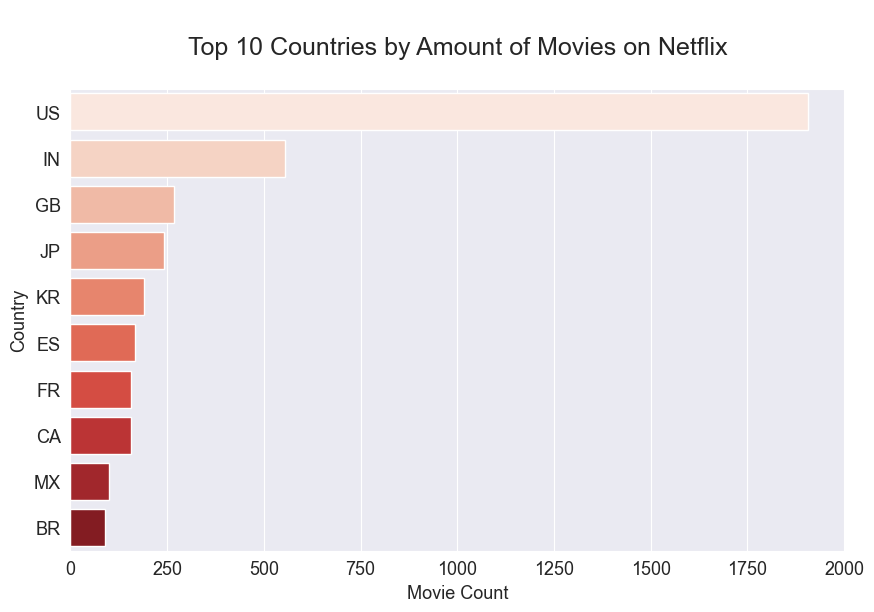

In [16]:
# A Bar chart that answer's the question: Which country produces the most content on Netflix?
df_country = df['production_countries'].value_counts().head(10)  # Removed unnecessary pd.DataFrame()

# Set up figure size
plt.figure(figsize=(10, 6))

# Set title
plt.title('\nTop 10 Countries by Amount of Movies on Netflix\n', fontsize=18)

# Create bar chart
sns.barplot(y=df_country.index, x=df_country.values, palette='Reds')  # Fixed sns.countplot() mistake

# Set labels
plt.xlabel('Movie Count')
plt.ylabel('Country')

# Show plot
plt.show()
#Analysis: Countries of movie production

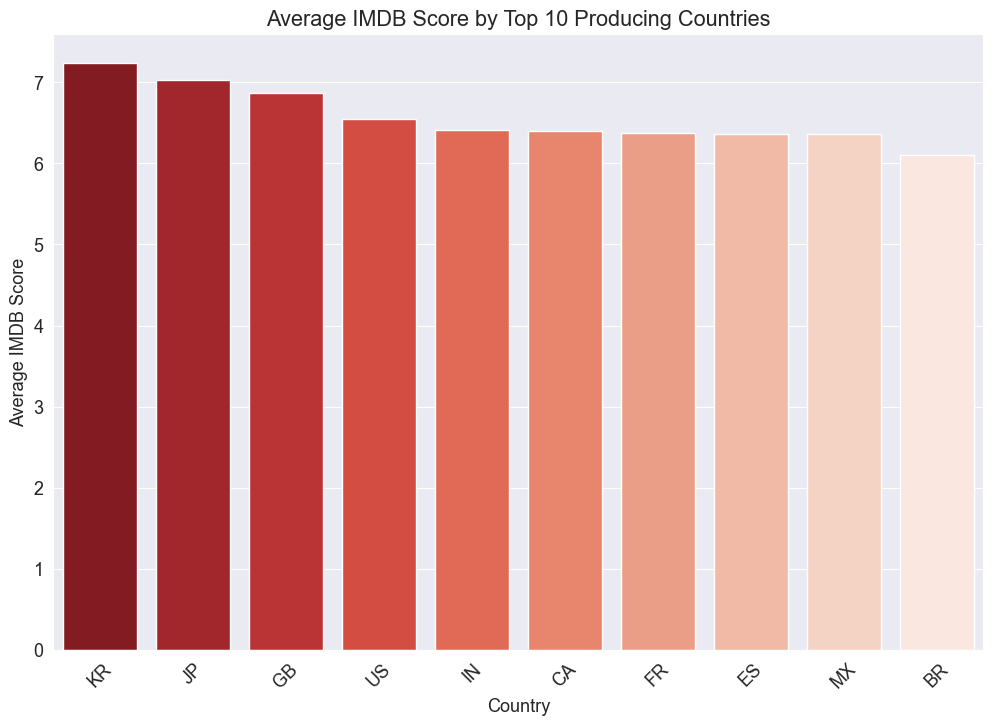

In [17]:
top_10_countries = df['production_countries'].value_counts().head(10)
top_10_countries = top_10_countries.sort_values(ascending=False)
top_10_countries = top_10_countries.index.tolist()
df_top_10 = df[df['production_countries'].isin(top_10_countries)]
avg_scores_by_country = df_top_10.groupby('production_countries')['imdb_score'].mean()
avg_scores_by_country = avg_scores_by_country.sort_values(ascending=False)
plt.figure(figsize=(12,8))
sns.set_palette('Reds_r')
sns.barplot(avg_scores_by_country.index, avg_scores_by_country.values, palette='Reds_r')
plt.title('Average IMDB Score by Top 10 Producing Countries')
plt.xlabel('Country')
sns.set_palette('Reds_r')
plt.xticks(rotation=45)
plt.ylabel('Average IMDB Score')
plt.show()

In [18]:
US_df = df[df['production_countries'] == 'US']
IN_df = df[df['production_countries'] == 'IN']
GB_df = df[df['production_countries'] == 'GB']
US_count = US_df['title'].count()
IN_count = IN_df['title'].count()
GB_count = GB_df['title'].count()
print(US_count)
print(IN_count)
print(GB_count)

1908
556
269


<AxesSubplot:xlabel='count', ylabel='genres'>

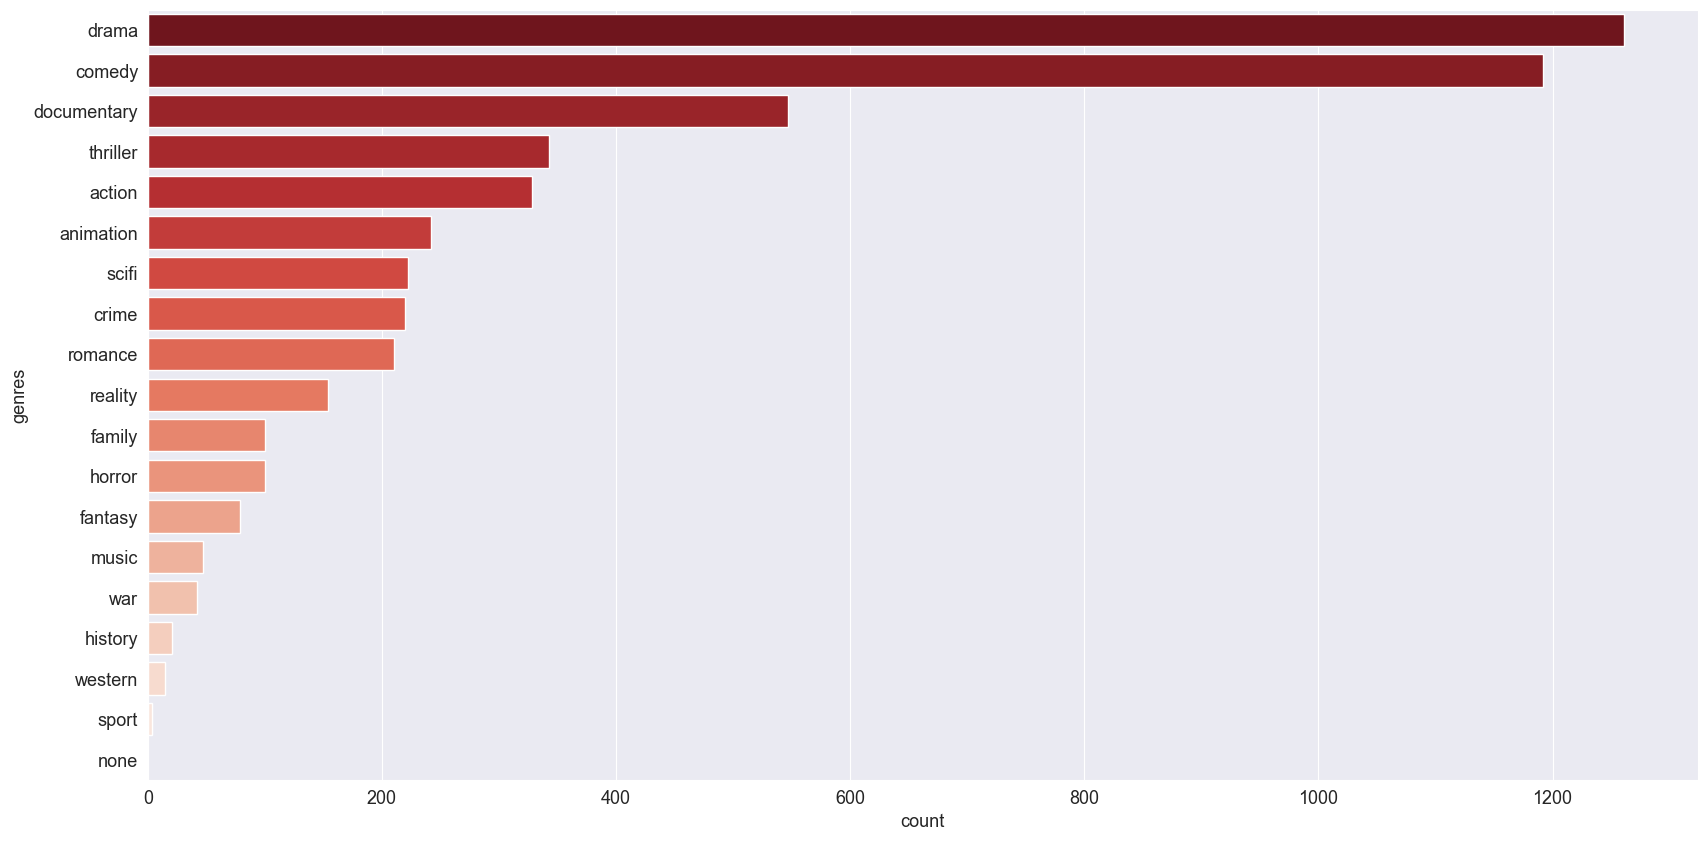

In [19]:
#Distribution of Genres
df['genres'].replace(to_replace='documentation', value='documentary', inplace=True)
filtered_df = df[df['genres'] != 'none']
plt.figure(figsize=(20,10))
sns.countplot(data=filtered_df, y='genres', palette='Reds_r', order=df['genres'].value_counts().index)

In [20]:
drama_df = df[df['genres'] == 'drama']
comedy_df = df[df['genres'] == 'comedy']
doc_df = df[df['genres'] == 'documentary']
drama_count = drama_df['title'].count()
comedy_count = comedy_df['title'].count()
doc_count = doc_df['title'].count()
print(drama_count)
print(comedy_count)
print(doc_count)

1261
1192
547


Text(0.5, 1.0, 'Total Released Content by Year')

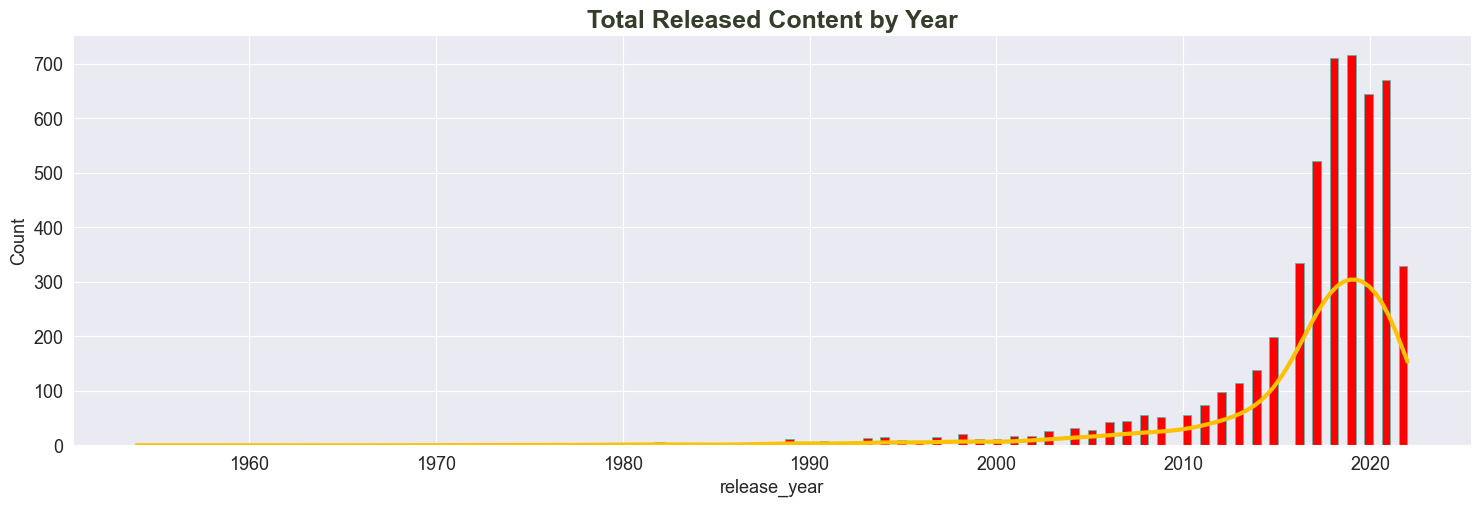

In [21]:
# Amount of movies based on release_year
sns.displot(data=df, x='release_year', kind='hist', kde=True,
color='#fdc100', facecolor='red', edgecolor='#64b6ac', line_kws={'lw': 3}, aspect=3)
plt.title('Total Released Content by Year', fontsize=18, weight=600, color='#333d29')

In [22]:
max_df = df[df['release_year'] == 2019]
max_count = max_df['title'].count()
print(max_count)

715


In [23]:
# Get the minimum release year
min_release_year = df['release_year'].min()
print(min_release_year)
min_df = df[df['release_year'] == 1954]
min_count = min_df['title'].count()
print(min_count)

1954
2


#Data Analytics Techniques: Natural Language Processing


In [24]:
df2 = df.copy()
df2 = df[df["type"] == "MOVIE"].reset_index(drop=True)
df2.shape

(3270, 10)

In [25]:
#Defining NLP functions
# Function to remove punctuation
def remove_punc(text):
    return text.translate(str.maketrans('', '', string.punctuation))  # Fixed indentation

# Function to convert text to lowercase
def go_lower(text):
    return text.lower()  

# Function to clean and remove all emojis, special characters, etc.
def no_emoji(text):
    return clean(text, no_emoji=True)

In [26]:
#Function implementation (con't)
from cleantext import clean
# Download necessary NLTK datasets
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Function to remove stopwords
def remove_stops(text):
    stop_words = set(stopwords.words("english"))  
    word_tokens = word_tokenize(text)  # Tokenize text
    filtered_sentence = [w for w in word_tokens if w.lower() not in stop_words]  # Remove stopwords
    return ' '.join(filtered_sentence)  # Return cleaned text

# Function to tokenize text
def tokenizer(text):
    return word_tokenize(text)  

# Function to lemmatize tokens
def lemmas(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]  

# Function to convert a list of tokens to a single string
def list_to_string(data):
    return " ".join(data) 

def no_emoji(text):
    return clean(text, no_emoji=True) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tsering\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tsering\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Tsering\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tsering\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Tsering\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [27]:
# Applying NLP Algorithm
df2["description"] = df2["description"].apply(no_emoji)
df2["description"] = df2["description"].apply(go_lower)
df2["description"] = df2["description"].apply(remove_punc)
df2["description"] = df2["description"].apply(remove_stops)
df2.head(3)

,title,type,description,release_year,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,production_countries,genres
0,Taxi Driver,MOVIE,mentally unstable vietnam war veteran works ni...,1976,8.2,808582.0,40.965,8.179,US,drama
1,Deliverance,MOVIE,intent seeing cahulawassee river turned one hu...,1972,7.7,107673.0,10.010,7.300,US,drama
2,Monty Python and the Holy Grail,MOVIE,king arthur accompanied squire recruits knight...,1975,8.2,534486.0,15.461,7.811,GB,fantasy


# Intuition behind TF-IDF Vectorizer

We take the  movie plot, cleaning them through some NLP techniques and then creating a TFIDF vectors for each plot. Then we get a huge TFIDF matrix from all the movie plots.

The TFIDF is a term frequency that counts the number of times each word shows up in the description. But it goes one step further and decreases the importance of highly frequent words in the description. If a word like 'earth' occurs very frequently in many movie plots then it really does not have that much weight and importance. On the other side a word like "Hobbit" is a word occuring in very few movies and hence any movies with the word "Hobbit" in the plot would generate a very high tfidf score

Based on the frequency of each word and the relative importance of the word the TFIDF is calculated and the scores can be structured as vectors





In [28]:
# Creating TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
# Create TFIDF object instance
tfidf = TfidfVectorizer()
# Generate the tfidf matrix from the plot descriptions
tfidf_matrix = tfidf.fit_transform(df2["description"])
# Compute the cosine similarity matrix
cosine_sim_tfidf = linear_kernel(tfidf_matrix, tfidf_matrix)

In [29]:
# Recommendation system: Based on the description, what movie/show is most similar?
# Create a simple function to extract the necessary info needed from our original dataframe
def get_df_info(df, _column, _index):
    info = df[_column][_index]  # Fixed indentation
    return info

# Recommendation system: Based on the description, what movie/show is most similar?
def recommendation_engine(movie_title, cosine_similar):
    recommended_movies = []
    movie_desc_list = []
    imdb_ids = []
    streaming_platform_list = []
    cost_list = []
    imdb_score_list = []

    # Obtain the index of our movie title
    index = df[df['title'] == movie_title].index[0]

    # Sort through our cosine similarity matrix and find the top 10 values for this specific movie title index
    similarity_score = pd.Series(cosine_similar[index]).sort_values(ascending=False)

    # Get index of these films
    top_10_content = similarity_score.iloc[1:11].index

    # Create a tuple for each film, we use the get_df_info function for ease of use
    movie_data = [
        (get_df_info(df, 'title', i), 
         get_df_info(df, 'type', i), 
         get_df_info(df, 'description', i), 
         get_df_info(df, 'release_year', i),
         get_df_info(df, 'imdb_score', i), 
         get_df_info(df, 'imdb_votes', i)) 
        for i in top_10_content if get_df_info(df, 'title', i) != movie_title
    ]

    # Append to our empty lists
    recommended_movies = [m[0] for m in movie_data]
    content_type = [m[1] for m in movie_data]
    description = [m[2] for m in movie_data]
    release_year = [m[3] for m in movie_data]
    imdb_score = [m[4] for m in movie_data]
    imdb_votes = [m[5] for m in movie_data]

    # Arrange them in a dictionary
    recommended_dict = {
        'Title': recommended_movies, 
        "Type": content_type,
        "Description": description,
        "Release Year": release_year, 
        "IMDB Score": imdb_score,
        "IMDB Votes": imdb_votes
    }

    recommended_df = pd.DataFrame.from_dict(recommended_dict)

    # Note that sometimes the same content is available in multiple streaming services, 
    # so we will do a groupby and show all the availabilities
    if recommended_df["Title"].duplicated().sum() > 0:
        recommended_df = recommended_df.groupby("Title", as_index=False, sort=False).agg({
            "Release Year": lambda x: ", ".join(map(str, x)),
            "IMDB Score": lambda y: ", ".join(map(str, y)),
            "Description": 'first', 
            "Type": 'first'
        })

    return recommended_df  

In [30]:
# What happens if we use the Movie 'Taxi Driver' as the recommendation
# Withdrew the tmdb_votes/scores for readability
recommendation_engine("Taxi Driver", cosine_sim_tfidf)

,Title,Type,Description,Release Year,IMDB Score,IMDB Votes
0,100 Days My Prince,SHOW,Lee Yool falls off a cliff and nearly dies in ...,2018,7.7,2068.0
1,13th,MOVIE,An in-depth look at the prison system in the U...,2016,8.2,35302.0
2,Thomas & Friends,SHOW,Thomas & Friends is a British children's telev...,1984,6.5,5104.0
3,Rise of the Guardians,MOVIE,When an evil spirit known as Pitch lays down t...,2012,7.2,173157.0
4,Meghnadbodh Rohoshyo,MOVIE,"A professor mysteriously vanishes, leaving beh...",2017,6.3,510.0
5,"Ron White: If You Quit Listening, I'll Shut Up",MOVIE,"Ron ""Tater Salad"" White dishes out his signatu...",2018,6.5,841.0
6,Trading Paint,MOVIE,A stock car racing legend is drawn back to the...,2019,4.4,1996.0
7,Bill Burr: Walk Your Way Out,MOVIE,No-nonsense comic Bill Burr takes the stage in...,2017,7.2,7256.0
8,Nightmare in Columbia County,MOVIE,The recounting of a terrible crime that wracke...,1991,5.5,345.0
9,Arjun: The Warrior Prince,MOVIE,Legend knows him as an archer of unwavering fo...,2012,6.7,14.0


In [31]:
# What happens if we use the Movie 'NCIS' as the recommendation
# Withdrew the tmdb_votes/scores for readability
recommendation_engine("NCIS", cosine_sim_tfidf)

,Title,Type,Description,Release Year,IMDB Score,IMDB Votes
0,Shikari,MOVIE,Shankar and Chanchal earn their living by doin...,1991,5.8,68.0
1,GoodFellas,MOVIE,"The true story of Henry Hill, a half-Irish, ha...",1990,8.7,1131681.0
2,Nightmare in Columbia County,MOVIE,The recounting of a terrible crime that wracke...,1991,5.5,345.0
3,Ragini MMS,MOVIE,"Out to relax and have fun at a farmhouse, a co...",2011,5.1,2654.0
4,Hush,MOVIE,A deaf woman is stalked by a psychotic killer ...,2016,6.6,123667.0
5,Te Ata,MOVIE,The extraordinary life of Chickasaw Nation cit...,2017,7.4,736.0
6,Dragons: Race to the Edge,SHOW,Unlock the secrets of the Dragon Eye and come ...,2015,8.2,6376.0
7,Old Thieves: The Legend of Artegio,MOVIE,Is the story of a generation of thieves who ac...,2007,8.0,317.0
8,Un + une,MOVIE,A successful film composer falls in love when ...,2015,6.2,2336.0
9,The Legend of Cocaine Island,MOVIE,A family man with no drug running experience s...,2018,6.3,3323.0


In [32]:
# Results:
# It is hard to say if these movie/shows are genuinely alike to Taxi Driver, simply based on the description.
#Limitations:
# Time
# With more time, we can invest more into the project -- working on a time crunch
# Computing Power
# Large datasets and larger recommendation models require more computing power/RAM
# Learning Curve
# One-hot encoding the genres
# Working with recommendation models
# Normalizing the votes
# In the future:
# A hybrid model may work to include the scores and genres as well
# Possibly by working to one-hot encode the genres
# Upskilling in NLP may benefit when making recommendation models
# We would also like to investigate the possibility of developing a predictive model that can determine
# the popularity of a TV show or movie onNetflixbased on various features such as its genre, rating,
# country of production and othe relevant factors.